# Current Testing Battery

In [1]:
import sys
import statistics
import numpy
from itertools import product
from timeit import default_timer as timer
try:
    from tqdm import tqdm
except ImportError:
    raise ImportError('tqdm is required. Please install it.')
sys.path.append("..")
import gillespy2
from scipy import stats
import matplotlib.pyplot as plt

In [18]:
# from gillespy2.solvers.numpy import NumPySSASolver
#BasicODESolver, BasicTauLeapingSolver, NumPySSASolver
# from gillespy2.solvers.cython import *
#CythonSSASolver
from gillespy2.solvers.numpy import TauLeapingSolver

from gillespy2.solvers.cpp import ODECSolver
from gillespy2.solvers.cpp import SSACSolver
#SSACSolver
# from gillespy2.solvers.auto import *
#SSASolver
from gillespy2.solvers.stochkit import StochKitSolver
#StochKitODESolver, StochKitSolver
from gillespy2.solvers.numpy.CLE_solver import CLESolver

In [19]:
from example_models import Example, MichaelisMenten

In [4]:
solvers = []
key, value = None, None
for key, value in globals().items():
    if isinstance(value, type) and issubclass(value, gillespy2.GillesPySolver) and value not in solvers:
        solvers.append(value)
print('Imported solvers:')
for i, solver in enumerate(solvers):
    print('{}:\t{}'.format(i+1, solver.name))

Imported solvers:
1:	TauLeapingSolver
2:	SSACSolver
3:	StochKitSolver
4:	CLESolver


In [5]:
import os
if 'STOCHKIT_HOME' not in os.environ:
    os.environ['STOCHKIT_HOME'] = "/home/smatthe2/StochKit"
# print("STOCHKIT_HOME =",os.environ['STOCHKIT_HOME'])

In [6]:
def __get_results(solver, model, number_of_trajectories):
    results = []
    for i in tqdm(range(number_of_trajectories), desc='Model: {0}, Solver: {1}'.format(model.name, solver.name)):
        result = model.run(solver=solver, show_labels=True)
        if isinstance(result, dict):
            results.append(result)
        else:
            results.append(result[0])
    return results

In [7]:
def create_distribution(solver, model, number_of_trajectories):
    results = __get_results(solver, model, number_of_trajectories)
    distribution = {}
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            distribution[species] = []
            for timestep in range(len(trajectory[species])):
                distribution[species].append([])
    trajectory_number = 0
    for trajectory in results:
        for species in trajectory.keys():
            if species == 'time': continue;
            for timestep in range(len(trajectory[species])):
                distribution[species][timestep].append(trajectory[species][timestep])
            
    return distribution    

In [8]:
def get_stats(solver, standard_results, model, number_of_trajectories):
    interior_stats = {}
    test_results = create_distribution(solver, model, number_of_trajectories)          
    for species in test_results:
        interior_stats[species] = []
    for species in test_results:
        for timestep, value in enumerate(test_results[species]):
            interior_stats[species].append(stats.ks_2samp(value, standard_results[species][timestep]))
    return interior_stats

In [9]:
# Use StochKit as 'standard' if it exists, otherwise 'SSACSolver'

try:
    standard_simulator = StochKitSolver
    _ = Example().run(solver=standard_simulator)
except gillespy2.SimulationError as e:
    standard_simulator = SSACSolver
print(f"standard simulator is {standard_simulator.name}")

standard simulator is SSACSolver


In [10]:
standard_results = {}
ks_stats = {}

number_of_trajectories = 50
http://localhost:9999/notebooks/test/TestingBattery.ipynb#
solver_list = solvers

model_list = [Example(), MichaelisMenten()]

for model in model_list:
    standard_results[model.name] = []
    ks_stats[model.name] = {}
    
for model in model_list:
    standard_results[model.name] = create_distribution(standard_simulator, model, number_of_trajectories)
    for solver in solver_list:
        if solver.name in ["BasicODESolver", "StochKitSolver", "StochKitODESolver",standard_simulator.name]:
            continue
        ks_stats[model.name][solver] = get_stats(solver, standard_results[model.name], model, number_of_trajectories)

Model: Example, Solver: SSACSolver:  16%|█▌        | 8/50 [00:39<03:30,  5.02s/it]2021-11-08 10:17:47,790 - root - WARNING - Makefile was interrupted during execution of target: 'ssa', unexpected behavior may occur.
2021-11-08 10:17:47,790 - root - WARNING - Makefile was interrupted during execution of target: 'ssa', unexpected behavior may occur.
2021-11-08 10:17:47,793 - root - WARNING - Please install/configure 'g++' and 'make' on your system, to ensure that GillesPy2 C solvers will run properly.
2021-11-08 10:17:47,793 - root - WARNING - Please install/configure 'g++' and 'make' on your system, to ensure that GillesPy2 C solvers will run properly.


SimulationError: argument 'solver=<class 'gillespy2.solvers.cpp.ssa_c_solver.SSACSolver'>' to run() failed.  Reason Given: local variable 'result' referenced before assignment

In [ ]:
for i in range(len(model_list)):
    model_name = model_list[i].name

    plt.figure(figsize=(18,10))
    for solver in solver_list:
        if solver in ks_stats[model_name]:
            plt.title("Error Comparison, model: " + model_name)
            plt.xlabel("Timestep")
            #plt.ylabel("P-Value")
            plt.ylabel("KS distance")
            for species in ks_stats[model_name][solver]:
                if species != 'time':            

                    result = ks_stats[model_name][solver][species][:]
                    timesteps = []
                    p_values = []
                    for timestep, value in enumerate(result):
                        timesteps.append(timestep)
                        ks, pv = value
                        p_values.append(ks)
                    plt.plot(timesteps, p_values, label='{0}: {1}'.format(solver.name, species))
    plt.legend(loc='best')
            
#             plt.plot(range(len(ks_stats[model_list[0].name][solver][species])), ks_stats[model_list[0].name][solver][species][:], label=solver.name)
# plt.legend(loc='best')
# for solver in solver_list:
#     print('Using Solver: ', solver.name)
#     for species in ks_stats[model_list[0].name][solver]:
#         if species is not 'time':
#             print('Species: ', species)
#             for timestep, timestep_result in enumerate(ks_stats[model_list[0].name][solver][species]):
#                 print('Timestep ', timestep, ': P-Value: ', timestep_result[1])
#                 plt.plot(timestep, timestep_result[1], label=species)
    

In [11]:
%time cresults = MichaelisMenten().run(solver=CLESolver, number_of_trajectories=100)

CPU times: user 10.7 s, sys: 2.84 ms, total: 10.7 s
Wall time: 10.7 s


In [12]:
%time sresults = MichaelisMenten().run(solver=SSACSolver, number_of_trajectories=100)

CPU times: user 59.7 ms, sys: 20 ms, total: 79.7 ms
Wall time: 4.28 s


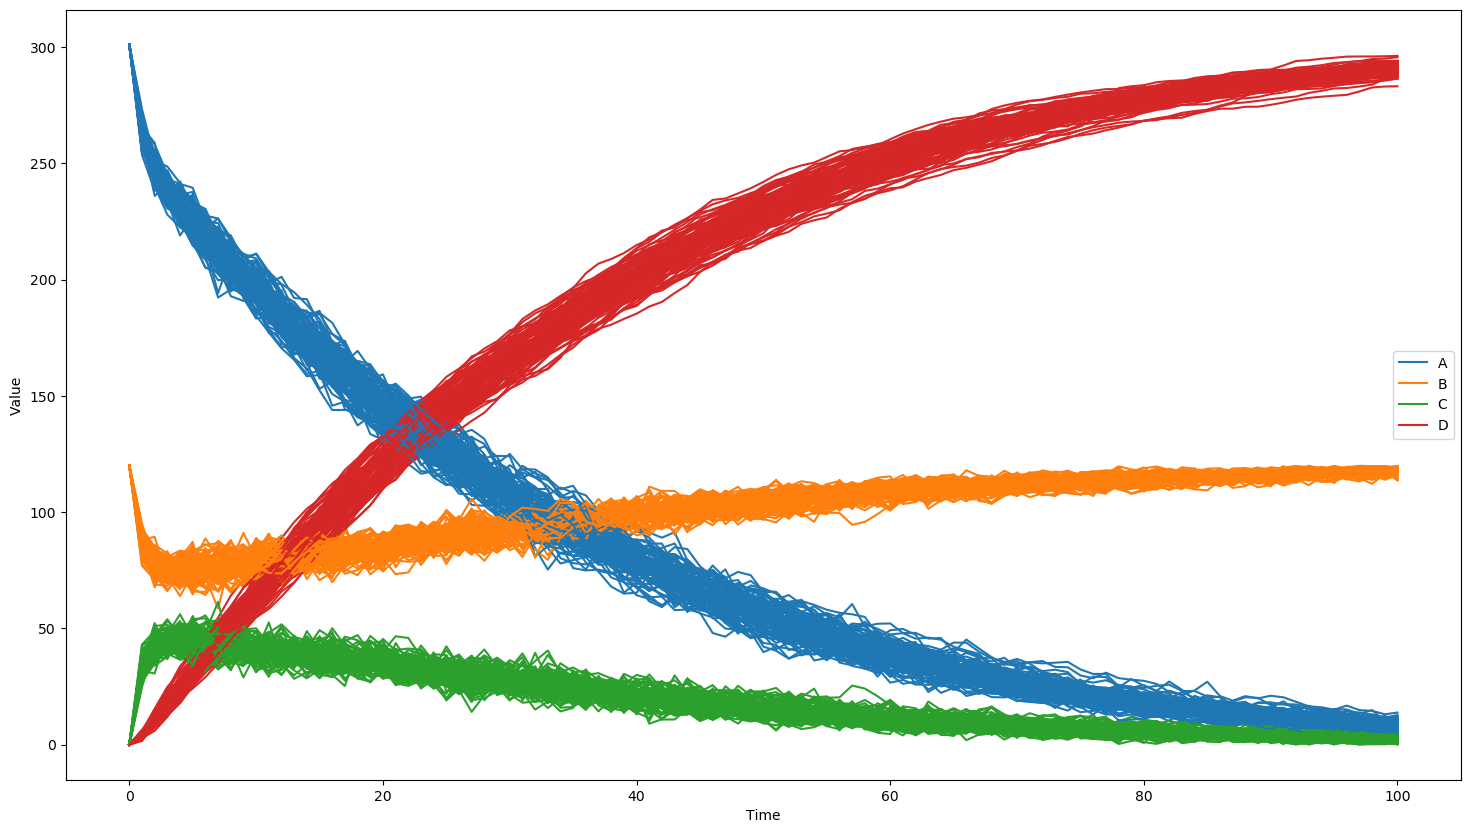

In [13]:
cresults.plot()

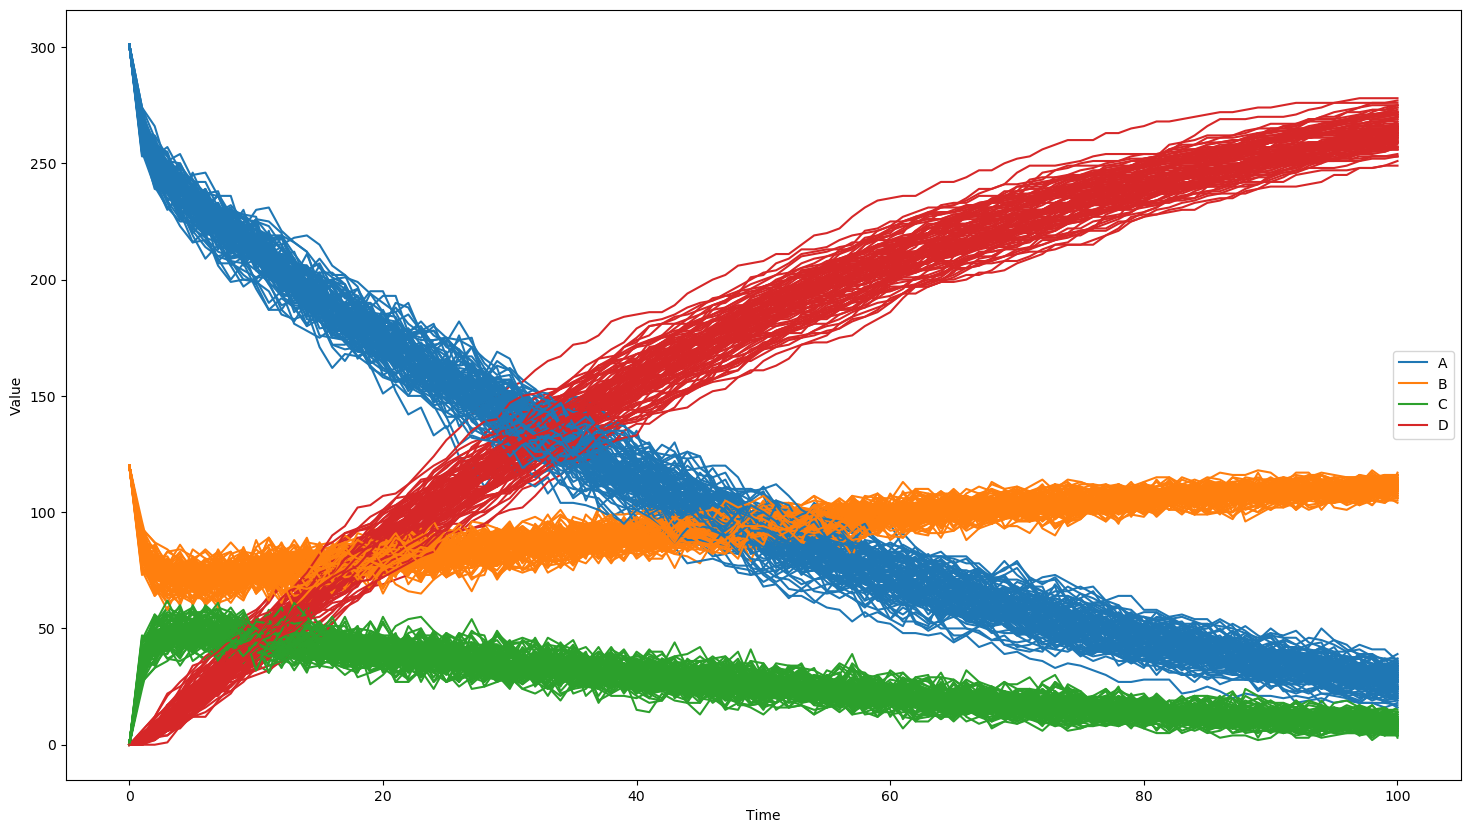

In [14]:
sresults.plot()

In [20]:
%time tresults = MichaelisMenten().run(solver=TauLeapingSolver, number_of_trajectories=100)

CPU times: user 7.4 s, sys: 48.1 ms, total: 7.45 s
Wall time: 7.48 s


In [21]:
%time oresults = MichaelisMenten().run(solver=ODECSolver, number_of_trajectories=1)

CPU times: user 11.6 ms, sys: 12 ms, total: 23.6 ms
Wall time: 10.8 s


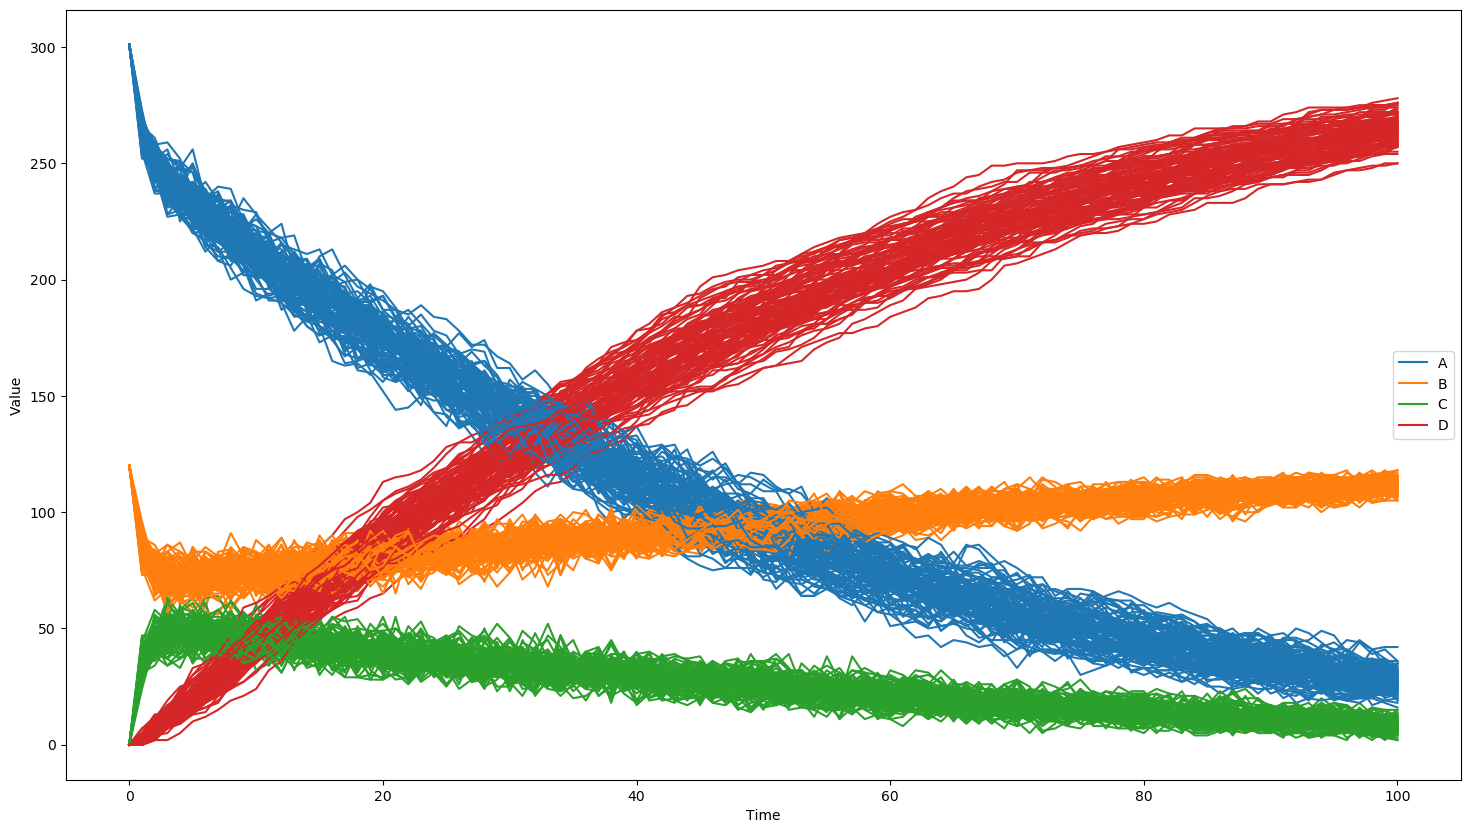

In [22]:
tresults.plot()

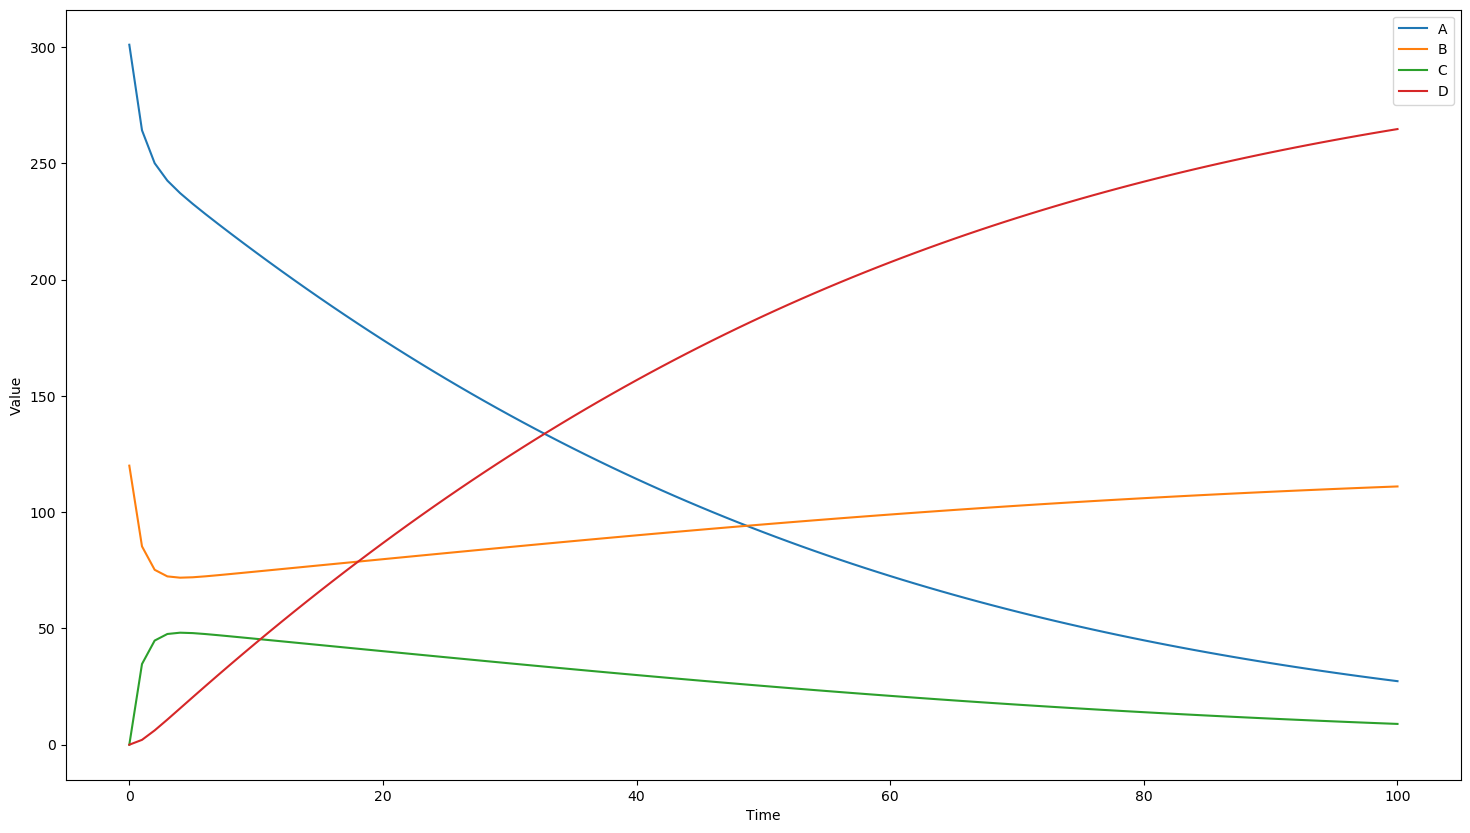

In [23]:
oresults.plot()